In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import (LogisticRegression, DecisionTreeClassifier, 
                                       RandomForestClassifier, GBTClassifier, NaiveBayes)
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("Fraud Detection with Spark MLlib") \
    .config("spark.master", "spark://spark-master:7077") \
    .getOrCreate()


In [12]:
# Step 2: Load Dataset from HDFS
data_path = "hdfs://namenode:9000/user/data/fraud.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [6]:
# Data preprocessing
# Handle missing values
#data = data.na.drop()

In [7]:
# EDA: Check for missing values
# missing_counts = data.select([(count(when(col(c).isNull(), c)) / count("*")).alias(c) for c in data.columns])
# missing_counts.show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
| 0.0| 0.0|   0.0|     0.0|          0.0|           0.0|     0.0|           0.0|           0.0|    0.0|           0.0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [13]:
print("The data contain %d records." % df.count())

The data contain 6362620 records.


In [14]:
print("The data contain %d columns." % len(df.columns))

The data contain 11 columns.


# Data Pre-processing 

In [15]:
### Get count of nan or missing values
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



### Observations:

This dataset is clean, no missing values.

In [16]:
# Schema of the data
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [17]:
from pyspark.sql.types import DoubleType

df = df.withColumn("step", df.step.cast(DoubleType()))
df = df.withColumn("amount", df.amount.cast(DoubleType()))
df = df.withColumn("oldbalanceOrg", df.oldbalanceOrg.cast(DoubleType()))
df = df.withColumn("newbalanceOrig", df.newbalanceOrig.cast(DoubleType()))
df = df.withColumn("oldbalanceDest", df.oldbalanceDest.cast(DoubleType()))
df = df.withColumn("newbalanceDest", df.newbalanceDest.cast(DoubleType()))
df = df.withColumn("isFraud", df.isFraud.cast('int'))

In [18]:
# Check column data types
df.dtypes

[('step', 'double'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('isFlaggedFraud', 'int')]

In [19]:
df = df.drop('isFlaggedFraud')

In [20]:
# Input variables : step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest
# Output Variable : isFraud

# EDA : Feature Engineering



In [21]:
df.describe().show()

+-------+------------------+--------+-----------------+-----------+------------------+------------------+-----------+------------------+------------------+--------------------+
|summary|              step|    type|           amount|   nameOrig|     oldbalanceOrg|    newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|
+-------+------------------+--------+-----------------+-----------+------------------+------------------+-----------+------------------+------------------+--------------------+
|  count|           6362620| 6362620|          6362620|    6362620|           6362620|           6362620|    6362620|           6362620|           6362620|             6362620|
|   mean|243.39724563151657|    NULL|179861.9035491287|       NULL| 833883.1040744762| 855113.6685785811|       NULL| 1100701.666519653|1224996.3982019224|0.001290820448180152|
| stddev|142.33197104913063|    NULL|603858.2314629209|       NULL|2888242.6730375267|2924048.5029542595|       NUL

In [22]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'double' or t[1]=='int']
df.select(numeric_features).describe().toPandas()

,summary,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,count,6362620,6362620,6362620,6362620,6362620,6362620,6362620
1,mean,243.39724563151657,179861.9035491287,833883.1040744762,855113.6685785811,1100701.6665196535,1224996.3982019224,0.001290820448180152
2,stddev,142.33197104913066,603858.2314629209,2888242.6730375267,2924048.502954259,3399180.1129944525,3674128.9421196915,0.035904796801604424
3,min,1.0,0.0,0.0,0.0,0.0,0.0,0
4,max,743.0,9.244551664E7,5.958504037E7,4.958504037E7,3.5601588935E8,3.5617927892E8,1


In [23]:
df.groupBy("isFraud").count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   8213|
|      0|6354407|
+-------+-------+



In [24]:
import seaborn as sns
from matplotlib import pyplot as plt
pd_df = df.toPandas()
print('Distribution of the Classes in the dataset')
print(pd_df['isFraud'].value_counts()/len(pd_df))

Py4JJavaError: An error occurred while calling o268.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Exception while getting task result: java.lang.IllegalStateException: unread block data
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4160)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4334)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4332)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4157)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)


NameError: name 'pd_df' is not defined

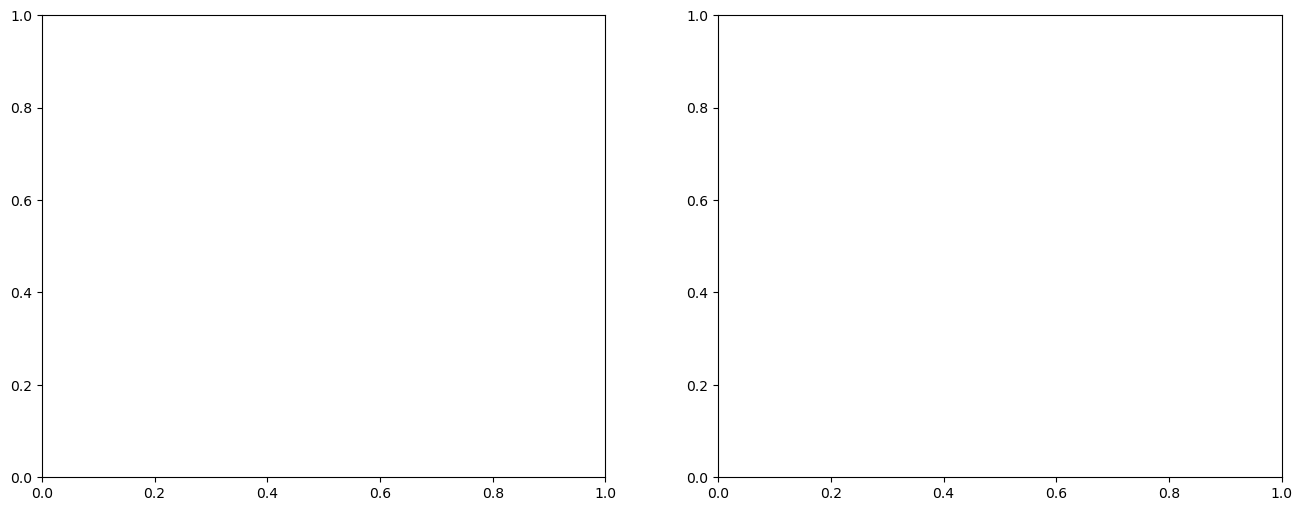

In [25]:
import matplotlib.pyplot as plt

# Définir les couleurs personnalisées
bar_colors = ['GREEN', 'YELLOW']  # Couleurs des barres
text_color = 'RED'  # Couleur du texte

# Créer une figure et des sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Diagramme à barres
axs[0].bar(['Non-Fraude', 'Fraude'], pd_df['isFraud'].value_counts(), color=bar_colors)
axs[0].set_xlabel('Type de transaction', fontsize=15, fontweight='bold')
axs[0].set_ylabel('Nombre d\'observations (Millions)', fontsize=15, fontweight='bold')
axs[0].set_title('Nombre d\'observations dans chaque classe', fontsize=18, fontweight='bold')
for i, val in enumerate(pd_df['isFraud'].value_counts()):
    axs[0].text(i, val + 3, str(val), fontsize=15, color=text_color, ha='center')

# Diagramme circulaire
axs[1].pie(pd_df['isFraud'].value_counts(), labels=['Non-Fraude', 'Fraude'], autopct='%.2f', colors=bar_colors)
axs[1].set_title('Répartition en pourcentage de chaque classe', fontsize=18, fontweight='bold')

# Afficher le graphique
plt.show()


# Data Pre-processing :

In [26]:
data = df

In [27]:
data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+
| 1.0| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|
| 1.0| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|
| 1.0|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|
| 1.0|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|
| 1.0| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|           0.0|           0.0|      0|
+----+--------+--------+-----------+-------------+--------------+-------

In [28]:
data['type', 'nameOrig', 'nameDest'].show(5)

+--------+-----------+-----------+
|    type|   nameOrig|   nameDest|
+--------+-----------+-----------+
| PAYMENT|C1231006815|M1979787155|
| PAYMENT|C1666544295|M2044282225|
|TRANSFER|C1305486145| C553264065|
|CASH_OUT| C840083671|  C38997010|
| PAYMENT|C2048537720|M1230701703|
+--------+-----------+-----------+
only showing top 5 rows



## separate nameOrig and nameDest :

In [29]:
import pyspark.sql.functions as F

data = (
    data.withColumn('str_orig', F.substring('nameOrig', 1,1))
    .withColumn('num_orig', F.col('nameOrig').substr(F.lit(2), F.length('nameOrig') - F.lit(1)))
)
data = data.drop('nameOrig')
# show df
data.show(5)

+----+--------+--------+-------------+--------------+-----------+--------------+--------------+-------+--------+----------+
|step|    type|  amount|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|str_orig|  num_orig|
+----+--------+--------+-------------+--------------+-----------+--------------+--------------+-------+--------+----------+
| 1.0| PAYMENT| 9839.64|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|       C|1231006815|
| 1.0| PAYMENT| 1864.28|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|       C|1666544295|
| 1.0|TRANSFER|   181.0|        181.0|           0.0| C553264065|           0.0|           0.0|      1|       C|1305486145|
| 1.0|CASH_OUT|   181.0|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|       C| 840083671|
| 1.0| PAYMENT|11668.14|      41554.0|      29885.86|M1230701703|           0.0|           0.0|      0|       C|2048537720|
+----+--

In [30]:
data = data.withColumn("num_orig", data.num_orig.cast(DoubleType()))

In [31]:
import pyspark.sql.functions as F

data = (
    data.withColumn('str_dest', F.substring('nameDest', 1,1))
    .withColumn('num_dest', F.col('nameDest').substr(F.lit(2), F.length('nameDest') - F.lit(1)))
)
data = data.drop('nameDest')
# show df
data.show(5)

+----+--------+--------+-------------+--------------+--------------+--------------+-------+--------+-------------+--------+----------+
|step|    type|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|str_orig|     num_orig|str_dest|  num_dest|
+----+--------+--------+-------------+--------------+--------------+--------------+-------+--------+-------------+--------+----------+
| 1.0| PAYMENT| 9839.64|     170136.0|     160296.36|           0.0|           0.0|      0|       C|1.231006815E9|       M|1979787155|
| 1.0| PAYMENT| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      0|       C|1.666544295E9|       M|2044282225|
| 1.0|TRANSFER|   181.0|        181.0|           0.0|           0.0|           0.0|      1|       C|1.305486145E9|       C| 553264065|
| 1.0|CASH_OUT|   181.0|        181.0|           0.0|       21182.0|           0.0|      1|       C| 8.40083671E8|       C|  38997010|
| 1.0| PAYMENT|11668.14|      41554.0|      29885.86|  

In [32]:
data = data.withColumn("num_dest", data.num_orig.cast(DoubleType()))

In [33]:
data.dtypes

[('step', 'double'),
 ('type', 'string'),
 ('amount', 'double'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('str_orig', 'string'),
 ('num_orig', 'double'),
 ('str_dest', 'string'),
 ('num_dest', 'double')]

## Apply OneHotEncoder to type, str_orig and str_dest columns

### type column :

In [35]:
from pyspark.ml.feature import StringIndexer
type_indexer = StringIndexer(inputCol="type", outputCol="typeIndex")
#Fits a model to the input dataset with optional parameters.
data = type_indexer.fit(data).transform(data)
data = data.drop('type')
data.show(5)

+----+--------+-------------+--------------+--------------+--------------+-------+--------+-------------+--------+-------------+---------+
|step|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|str_orig|     num_orig|str_dest|     num_dest|typeIndex|
+----+--------+-------------+--------------+--------------+--------------+-------+--------+-------------+--------+-------------+---------+
| 1.0| 9839.64|     170136.0|     160296.36|           0.0|           0.0|      0|       C|1.231006815E9|       M|1.231006815E9|      1.0|
| 1.0| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      0|       C|1.666544295E9|       M|1.666544295E9|      1.0|
| 1.0|   181.0|        181.0|           0.0|           0.0|           0.0|      1|       C|1.305486145E9|       C|1.305486145E9|      3.0|
| 1.0|   181.0|        181.0|           0.0|       21182.0|           0.0|      1|       C| 8.40083671E8|       C| 8.40083671E8|      0.0|
| 1.0|11668.14|      41554.

In [36]:
data.groupBy("typeIndex").count().show()

+---------+-------+
|typeIndex|  count|
+---------+-------+
|      0.0|2237500|
|      1.0|2151495|
|      4.0|  41432|
|      3.0| 532909|
|      2.0|1399284|
+---------+-------+



### str_orig column

In [37]:
nameOrig_indexer = StringIndexer(inputCol="str_orig", outputCol="nameOrigIndex")
#Fits a model to the input dataset with optional parameters.
data = nameOrig_indexer.fit(data).transform(data).drop('str_orig')
data.show(5)

+----+--------+-------------+--------------+--------------+--------------+-------+-------------+--------+-------------+---------+-------------+
|step|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|     num_orig|str_dest|     num_dest|typeIndex|nameOrigIndex|
+----+--------+-------------+--------------+--------------+--------------+-------+-------------+--------+-------------+---------+-------------+
| 1.0| 9839.64|     170136.0|     160296.36|           0.0|           0.0|      0|1.231006815E9|       M|1.231006815E9|      1.0|          0.0|
| 1.0| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      0|1.666544295E9|       M|1.666544295E9|      1.0|          0.0|
| 1.0|   181.0|        181.0|           0.0|           0.0|           0.0|      1|1.305486145E9|       C|1.305486145E9|      3.0|          0.0|
| 1.0|   181.0|        181.0|           0.0|       21182.0|           0.0|      1| 8.40083671E8|       C| 8.40083671E8|      0.0|       

### str_dest column

In [38]:
nameDest_indexer = StringIndexer(inputCol="str_dest", outputCol="nameDestIndex")
#Fits a model to the input dataset with optional parameters.
data = nameDest_indexer.fit(data).transform(data).drop('str_dest')
data.show(5)

+----+--------+-------------+--------------+--------------+--------------+-------+-------------+-------------+---------+-------------+-------------+
|step|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|     num_orig|     num_dest|typeIndex|nameOrigIndex|nameDestIndex|
+----+--------+-------------+--------------+--------------+--------------+-------+-------------+-------------+---------+-------------+-------------+
| 1.0| 9839.64|     170136.0|     160296.36|           0.0|           0.0|      0|1.231006815E9|1.231006815E9|      1.0|          0.0|          1.0|
| 1.0| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      0|1.666544295E9|1.666544295E9|      1.0|          0.0|          1.0|
| 1.0|   181.0|        181.0|           0.0|           0.0|           0.0|      1|1.305486145E9|1.305486145E9|      3.0|          0.0|          0.0|
| 1.0|   181.0|        181.0|           0.0|       21182.0|           0.0|      1| 8.40083671E8| 8.4008367

In [39]:
data.dtypes

[('step', 'double'),
 ('amount', 'double'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('num_orig', 'double'),
 ('num_dest', 'double'),
 ('typeIndex', 'double'),
 ('nameOrigIndex', 'double'),
 ('nameDestIndex', 'double')]

In [40]:
data.show(5)

+----+--------+-------------+--------------+--------------+--------------+-------+-------------+-------------+---------+-------------+-------------+
|step|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|     num_orig|     num_dest|typeIndex|nameOrigIndex|nameDestIndex|
+----+--------+-------------+--------------+--------------+--------------+-------+-------------+-------------+---------+-------------+-------------+
| 1.0| 9839.64|     170136.0|     160296.36|           0.0|           0.0|      0|1.231006815E9|1.231006815E9|      1.0|          0.0|          1.0|
| 1.0| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      0|1.666544295E9|1.666544295E9|      1.0|          0.0|          1.0|
| 1.0|   181.0|        181.0|           0.0|           0.0|           0.0|      1|1.305486145E9|1.305486145E9|      3.0|          0.0|          0.0|
| 1.0|   181.0|        181.0|           0.0|       21182.0|           0.0|      1| 8.40083671E8| 8.4008367

In [41]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
                                       'newbalanceDest', 'num_orig', 'num_dest', 'typeIndex','nameOrigIndex',
                                       'nameDestIndex'], outputCol='features')
data = assembler.transform(data)

In [42]:
data['features','isFraud'].show(5)

+--------------------+-------+
|            features|isFraud|
+--------------------+-------+
|[9839.64,170136.0...|      0|
|[1864.28,21249.0,...|      0|
|(10,[0,1,5,6,7],[...|      1|
|(10,[0,1,3,5,6],[...|      1|
|[11668.14,41554.0...|      0|
+--------------------+-------+
only showing top 5 rows



## Split the data into Train and test sets :

In [43]:
(train, test )= data.randomSplit([0.8, 0.2], seed=23)

In [44]:
[train.count(), test.count()]

[5090003, 1272617]

# Gradient-Boosted Tree Classifier

In [45]:
from pyspark.ml.classification import GBTClassifier

# Train a GBT model.
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features", maxIter=10)

# Train model. 
gbt_model = gbt.fit(train)

In [46]:
# Make predictions.
prediction_GBT = gbt_model.transform(test)

In [47]:
prediction_GBT.groupBy("isFraud", "prediction").count().show()

+-------+----------+-------+
|isFraud|prediction|  count|
+-------+----------+-------+
|      1|       0.0|    425|
|      0|       0.0|1270896|
|      1|       1.0|   1178|
|      0|       1.0|    118|
+-------+----------+-------+



In [48]:
tp = prediction_GBT[(prediction_GBT.isFraud == 1) & (prediction_GBT.prediction == 1)].count()
tn = prediction_GBT[(prediction_GBT.isFraud == 0) & (prediction_GBT.prediction == 0)].count()
fp = prediction_GBT[(prediction_GBT.isFraud == 0) & (prediction_GBT.prediction == 1)].count()
fn = prediction_GBT[(prediction_GBT.isFraud == 1) & (prediction_GBT.prediction == 0)].count()
recall_GBT = tp/(tp+fn)
precision_GBT = tp/(tp+fp)
f1_score_GBT = 2*(recall_GBT*precision_GBT)/(recall_GBT+precision_GBT)
print("Recall : ",recall_GBT)
print("Precision : ", precision_GBT)
print("F1 Score : ", f1_score_GBT)

Recall :  0.7348721147847785
Precision :  0.9089506172839507
F1 Score :  0.8126940324249742
